In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/

/content/drive/MyDrive/Colab Notebooks


In [3]:
from PIL import Image
from IPython.display import display
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model
from tensorflow.python.keras import models
import os
from tensorflow.keras.applications import VGG19

In [4]:
def load_image(image_path):
      img = keras.preprocessing.image.load_img(image_path)

      max_dim=512
      factor=max_dim/max(img.size)
      img=img.resize((round(img.size[0]*factor),round(img.size[1]*factor)),Image.ANTIALIAS)

      img = keras.preprocessing.image.img_to_array(img)
      img = tf.expand_dims(img, axis=0)
      return img

In [5]:
def plot_pair(content_img, style_img):
  content = np.squeeze(content_img, axis=0)
  style = np.squeeze(style_img, axis=0)
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(content / 255.0)
  plt.title('Content Image')
  plt.subplot(1, 2, 2)
  plt.imshow(style / 255.0)
  plt.title('Style Image')
  plt.show()

In [ ]:
content_path = "windows.jpg"
style_path = "starrynight.jpeg"

content_img = load_image(content_path)
style_img = load_image(style_path)

<ipython-input-56-4f9e73e7f89e>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img=img.resize((round(img.size[0]*factor),round(img.size[1]*factor)),Image.ANTIALIAS)


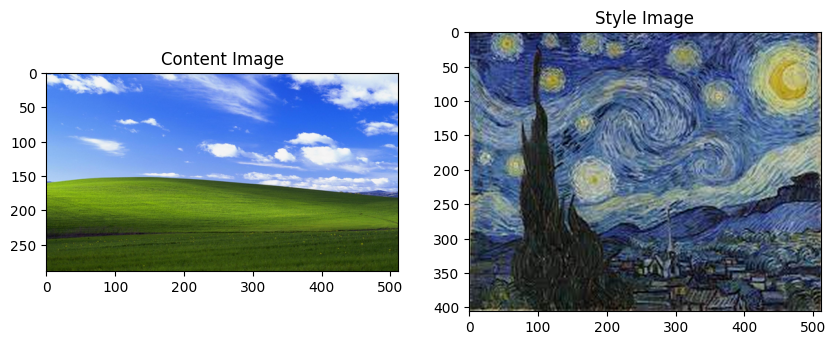

In [ ]:
plot_pair(content_img, style_img)

In [ ]:
content_img.shape

TensorShape([1, 288, 512, 3])

In [ ]:
style_img.shape

TensorShape([1, 406, 512, 3])

In [ ]:
new_img = tf.keras.applications.vgg19.preprocess_input(content_img)
new_img = tf.Variable(new_img ,dtype=tf.float32)

In [9]:
# ucitavanje modela, bez poslednjeg sloja
vgg19 = VGG19(weights='imagenet', include_top=False)
vgg19.trainable = False

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg19.layers:
  print(layer.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [12]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
from tensorflow.keras.applications.vgg19 import preprocess_input

In [13]:
def compute_content_loss(content, target):
    return tf.reduce_mean(tf.square(content - target))

def gram_matrix(tensor):
    channels=int(tensor.shape[-1])
    vector=tf.reshape(tensor,[-1,channels])
    n=tf.shape(vector)[0]
    gram_matrix=tf.matmul(vector,vector,transpose_a=True)
    return gram_matrix/tf.cast(n,tf.float32)

def compute_style_loss(style, target):
    style_gram = gram_matrix(style)
    target_gram = gram_matrix(target)
    return tf.reduce_mean(tf.square(style_gram-target_gram))

In [14]:
def get_layers(vgg, style_layers, content_layers):

    content_output=[vgg.get_layer(layer).output for layer in content_layers]
    style_output=[vgg.get_layer(layer).output for layer in style_layers]

    model_output= style_output+content_output

    return models.Model(vgg.input,model_output)

In [15]:
model = get_layers(vgg19, style_layers, content_layers)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


In [16]:
def compute_total_loss(model, loss_weights, init_image, content_image, style_image):

    content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
    style_image = tf.keras.applications.vgg19.preprocess_input(style_image)

    content_output = model(content_image)
    style_output = model(style_image)

    content_features = content_output[num_style_layers:]
    style_features = style_output[:num_style_layers]

    target_output = model(init_image)
    target_content_features = target_output[num_style_layers:]
    target_style_features = target_output[:num_style_layers]

    content_loss = 0
    style_loss = 0

    content_loss += loss_weights['content'] * compute_content_loss(content_features[0], target_content_features[0])

    for original_style, target_style in zip(style_features, target_style_features):
        style_loss += loss_weights['style'] * compute_style_loss(original_style[0], target_style[0])

    total_loss = content_loss + style_loss
    return total_loss

In [17]:
def deprocess_img(processed_img):
  x = processed_img.copy()
  if len(x.shape) == 4:
    x = np.squeeze(x, 0)
  assert len(x.shape) == 3 #Input dimension must be [1, height, width, channel] or [height, width, channel]


  # perform the inverse of the preprocessing step
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  x = x[:, :, ::-1]

  x = np.clip(x, 0, 255).astype('uint8')
  return x

In [ ]:
#refractor to function

total_variation_weight = 30
content_weight = 0.0005 # alpha
style_weight = 0.5 # beta
num_iterations = 100
learning_rate = 10.0
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

loss_weights = {
    'style': style_weight,
    'content': content_weight,
    'total_variation': total_variation_weight
}

# Optimization loop
init_image = tf.keras.applications.vgg19.preprocess_input(new_img)
for iteration in range(num_iterations):
    with tf.GradientTape() as tape:
        total_loss = compute_total_loss(model, loss_weights, new_img, content_img, style_img)

    gradients = tape.gradient(total_loss, new_img)
    optimizer.apply_gradients([(gradients, new_img)])

    clipped_image = tf.clip_by_value(new_img, 0.0, 255.0)
    new_img.assign(clipped_image)

    if iteration % 10 == 0:
        print("Iteration:", iteration, "Total Loss:", total_loss.numpy())

        pic = deprocess_img(new_img.numpy())

        plt.imshow(pic)
        plt.title('Stylized Image')
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

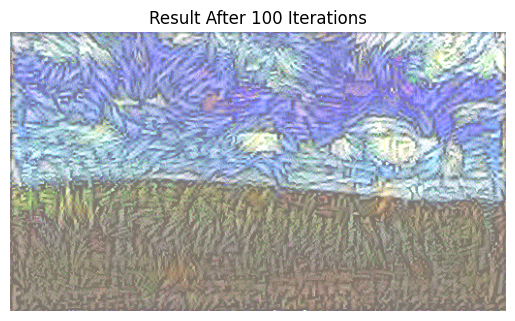

In [ ]:
pic = deprocess_img(new_img.numpy())

plt.imshow(pic)
plt.title('Result After 100 Iterations')
plt.axis('off')
plt.show()

In [7]:
content_path = "cat.jpg"
style_path = "famous_cat.jpg"

content_img = load_image(content_path)
style_img = load_image(style_path)

<ipython-input-4-4f9e73e7f89e>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img=img.resize((round(img.size[0]*factor),round(img.size[1]*factor)),Image.ANTIALIAS)


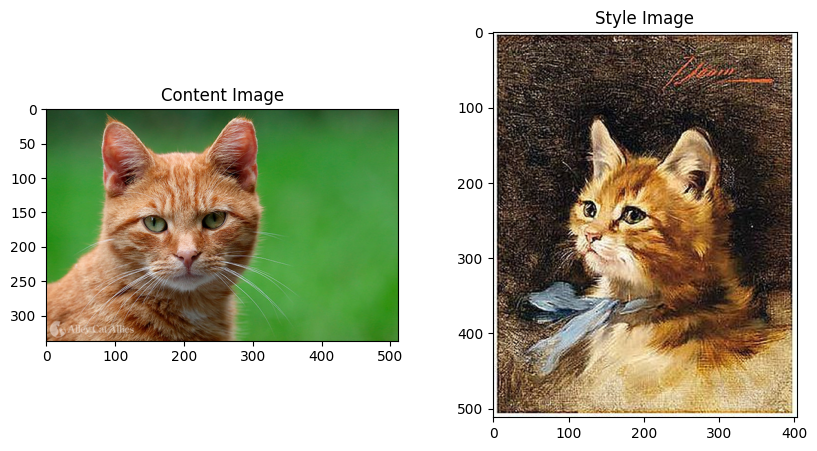

In [8]:
plot_pair(content_img, style_img)

In [10]:
new_img = tf.keras.applications.vgg19.preprocess_input(content_img)
new_img = tf.Variable(new_img ,dtype=tf.float32)

In [18]:
total_variation_weight = 30
content_weight = 0.0005 # alpha
style_weight = 0.5 # beta
num_iterations = 100
learning_rate = 10.0
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

loss_weights = {
    'style': style_weight,
    'content': content_weight,
    'total_variation': total_variation_weight
}

# Optimization loop
init_image = tf.keras.applications.vgg19.preprocess_input(new_img)
for iteration in range(num_iterations):
    with tf.GradientTape() as tape:
        total_loss = compute_total_loss(model, loss_weights, new_img, content_img, style_img)

    gradients = tape.gradient(total_loss, new_img)
    optimizer.apply_gradients([(gradients, new_img)])

    clipped_image = tf.clip_by_value(new_img, 0.0, 255.0)
    new_img.assign(clipped_image)

    if iteration % 10 == 0:
        print("Iteration:", iteration, "Total Loss:", total_loss.numpy())

        pic = deprocess_img(new_img.numpy())

        plt.imshow(pic)
        plt.title('Stylized Image')
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.

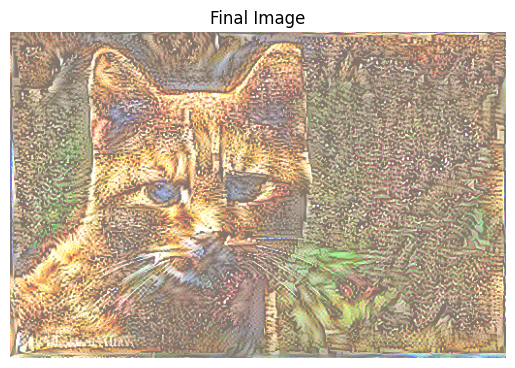

In [20]:
pic = deprocess_img(new_img.numpy())
plt.imshow(pic)
plt.title('Final Image')
plt.axis('off')
plt.show()

In [40]:
content_path = "cat.jpg"
style_path = "famous_cat.jpg"

content_img = load_image(content_path)
style_img = load_image(style_path)

<ipython-input-4-4f9e73e7f89e>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img=img.resize((round(img.size[0]*factor),round(img.size[1]*factor)),Image.ANTIALIAS)


In [41]:
new_img = tf.keras.applications.vgg19.preprocess_input(content_img)
new_img = tf.Variable(new_img ,dtype=tf.float32)

In [42]:
total_variation_weight = 30
content_weight = 0.5 # alpha
style_weight = 0.000005 # beta
num_iterations = 100
learning_rate = 10.0
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

loss_weights = {
    'style': style_weight,
    'content': content_weight,
    'total_variation': total_variation_weight
}

# Optimization loop
init_image = tf.keras.applications.vgg19.preprocess_input(new_img)
for iteration in range(num_iterations):
    with tf.GradientTape() as tape:
        total_loss = compute_total_loss(model, loss_weights, new_img, content_img, style_img)

    gradients = tape.gradient(total_loss, new_img)
    optimizer.apply_gradients([(gradients, new_img)])

    clipped_image = tf.clip_by_value(new_img, 0.0, 255.0)
    new_img.assign(clipped_image)

    if iteration % 10 == 0:
        print("Iteration:", iteration, "Total Loss:", total_loss.numpy())

        pic = deprocess_img(new_img.numpy())

        plt.imshow(pic)
        plt.title('Stylized Image')
        plt.axis('off')
        plt.show()

Output hidden; open in https://colab.research.google.com to view.